In [59]:
import pandas as pd
import numpy as np
import re
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import cm
import contextily as cx
import matplotlib as mpl
%matplotlib inline

In [122]:
def distance_from_lonlat(p1,p2):
    # https://github.com/openlayers/openlayers/blob/release-2.12/lib/OpenLayers/Util.js#L750
    #VincentyConstants
    a = 6378137
    b = 6356752.3142
    f = 1/298.257223563
    
    p1_lon = (np.pi/180) * p1[0]
    p1_lat = (np.pi/180) * p1[1]
    p2_lon = (np.pi/180) * p2[0]
    p2_lat = (np.pi/180) * p2[1]
    
    L = p2_lon - p1_lon
    U1 = np.arctan((1-f) * np.tan(p1_lat))
    U2 = np.arctan((1-f) * np.tan(p2_lat))
    
    lambda_ = L
    lambdaP = 2*np.pi
    iterLimit = 30
    
    while(np.abs(lambda_ - lambdaP) > 1e-13):
        sinSigma = np.sqrt((np.cos(U2)*np.sin(lambda_))**2 + (np.cos(U1)*np.sin(U2)- np.sin(U1)*np.cos(U2)*np.cos(lambda_))**2)
        if (sinSigma == 0):
            return 0
        cosSigma = np.sin(U1)*np.sin(U2) + np.cos(U1)*np.cos(U2)*np.cos(lambda_)
        sigma = np.arctan2(sinSigma, cosSigma)
        alpha = np.arcsin(np.cos(U1)*np.cos(U2)*np.sin(lambda_)/sinSigma)
        CSM   = cosSigma - 2*np.sin(U1)*np.sin(U2)/(np.cos(alpha)**2)
        C     = (f/16)*np.cos(alpha)**2*(4+f*(4-3*(np.cos(alpha)**2)))
        lamdaP = lambda_
        lambda_ = L + (1-C)*f*np.sin(alpha)*(sigma + C*sinSigma*(CSM + C*cosSigma*(-1 +2*CSM**2)))
        iterLimit -= 1
        if iterLimit <= 0:
                        break
    uSq = np.cos(alpha)*(a**2 - b **2)/(b**2)
    A = 1 + uSq/16384*(4096+uSq*(-768+uSq*(320-175*uSq)))
    B = uSq/1024 * (256+uSq*(-128+uSq*(74-47*uSq)))
    deltaSigma = B*sinSigma*(CSM+B/4*(cosSigma*(-1+2*CSM**2)-
    B/6*CSM*(-3+4*sinSigma*sinSigma)*(-3+4*CSM**2)))
    s = b*A*(sigma-deltaSigma)
    return s
        

                                 
        
                        
    

In [60]:
## Load all the data
df = pd.read_csv("Data_Lv3_UMDOTS_Escooters.csv")

In [61]:
##Visualize the data frame
df.head()

,Unnamed: 0,Unnamed: 0.1,CREATED,START,END,DISTANCE,RIDE_ID,CUSTOMER_ID,MINUTES,VEHICLE_TYPE,PATH,TIMESTAMPS,START LONG,START LAT,END LONG,END LAT
0,0,0,2020-10-03 03:32:15+00:00,2020-10-03 03:32:15+00:00,2020-10-03 03:32:46+00:00,0.008,3135665,193964,1,Scooter,"{\n ""coordinates"": [\n [\n -76.934163...","[\n ""2020-10-03T03:32:14Z"",\n ""2020-10-03T03...",-76.934163,38.990656,-76.934285,38.990739
1,1,1,2020-10-03 03:07:39+00:00,2020-10-03 03:07:39+00:00,2020-10-03 03:37:06+00:00,1.062,3135395,542947,30,Scooter,"{\n ""coordinates"": [\n [\n -76.938180...","[\n ""2020-10-03T03:07:46Z"",\n ""2020-10-03T03...",-76.938181,38.982087,-76.949165,38.992849
2,2,2,2020-10-03 03:17:05+00:00,2020-10-03 03:17:05+00:00,2020-10-03 03:24:24+00:00,0.847,3135503,517321,8,Scooter,"{\n ""coordinates"": [\n [\n -76.937599...","[\n ""2020-10-03T03:17:12Z"",\n ""2020-10-03T03...",-76.937600,38.979613,-76.933335,38.992676
3,3,3,2020-10-03 02:24:58+00:00,2020-10-03 02:24:58+00:00,2020-10-03 03:11:56+00:00,3.447,3134955,578051,47,Scooter,"{\n ""coordinates"": [\n [\n -76.943553...","[\n ""2020-10-03T02:25:04Z"",\n ""2020-10-03T02...",-76.943553,38.982470,-76.943546,38.982476
4,4,4,2020-10-03 03:19:34+00:00,2020-10-03 03:19:34+00:00,2020-10-03 03:22:45+00:00,0.386,3135529,552305,4,Scooter,"{\n ""coordinates"": [\n [\n -76.938115...","[\n ""2020-10-03T03:19:40Z"",\n ""2020-10-03T03...",-76.938116,38.982084,-76.943257,38.986101


In [149]:
center_lon = -76.9388
center_lat = 38.9896
deg_extent = 0.02

import math
def merc(lat, lon):
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

min_lon = center_lon - deg_extent
max_lon = center_lon + deg_extent
min_lat = center_lat - deg_extent
max_lat = center_lat + deg_extent

lon_list = np.linspace(min_lon,max_lon, lon_size)
lat_list = np.linspace(min_lat,max_lat, lat_size)


delta_lon = lon_list[1] - lon_list[0]
delta_lat = lat_list[1] - lat_list[0]


x_min, y_max = merc(max_lat,max_lon)
x_max, y_min =  merc(min_lat,min_lon)

dist_x = distance_from_lonlat([max_lon,max_lat],[min_lon,max_lat])
dist_y = distance_from_lonlat([max_lon,max_lat],[max_lon,min_lat])

bin_side_length = 8

lat_size = int(np.ceil((dist_y)/bin_side_length))
lon_size = int(np.ceil((dist_x)/bin_side_length))

print(lat_size)
print(lon_size)

556
434


In [141]:
## Extract coordinates from path

def discard_outliers_from_path(x):
    results = []
    for coords in x:
        if( (np.abs(coords[0] - center_lon) < deg_extent) and (np.abs(coords[1] - center_lat) < deg_extent)):
            results.append(coords)
    return results

all_points = [] 
path_list = df['PATH'][:]
for str in path_list:
    path = re.findall(r"[+-]? *(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?", str)
    path = list(map(float,path))
    zipped = list(zip(path[::2],path[1::2]))
    all_points.extend(discard_outliers_from_path(zipped))

In [142]:
## Convert to immutable 
all_points = np.array(all_points)

In [143]:
def get_index(lon, lat, delta_lon, delta_lat, min_lon, min_lat):
    lon_idx = int((lon - min_lon)/delta_lon)
    lat_idx = int((lat - min_lat)/delta_lat)
    return lon_idx, lat_idx
    

In [144]:
west, south, east, north = (
    center_lon - deg_extent,
    center_lat - deg_extent,
    center_lon + deg_extent,
    center_lat + deg_extent
             )

img, ext = cx.bounds2raster(west,
                             south,
                             east,
                             north,
                             "map.svg",
                             source=cx.providers.Esri.WorldStreetMap(apiKey='AAPK8b5fa650819c4801bebdefa5a1713b90OFUuzP3MP-L84q66A4FBSolubI6QYaE4BjOLNiO5OvkDmO8IWpViq_qKaN0YWJot'),
                             ll=True
                            )

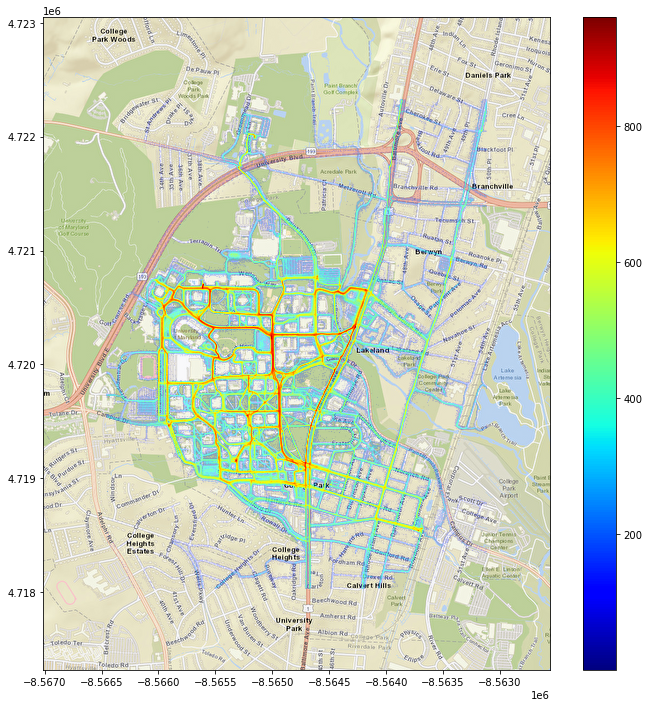

In [150]:
lod = 1.5
log_scale = True

cmap = mpl.cm.jet


points_map = np.ones((lon_list.size,lat_list.size))
for point in all_points:
    points_map[get_index(point[0], point[1], delta_lon, delta_lat, min_lon, min_lat)] += 1

if log_scale:
    points_map = np.log10(points_map)

alpha_map = points_map/np.max(points_map)

v_min = np.min(points_map)
v_max = np.max(points_map)

norm = mpl.colors.Normalize(vmin=10**v_min, vmax=10**v_max)


fig, ax = plt.subplots(figsize=(12,12))
#x_min, y_max = tilemapbase.project(max_lon,max_lat)
#x_max, y_min = tilemapbase.project(min_lon,min_lat)

rots = 1

plt.imshow(img,extent=ext,interpolation='sinc')
ax.imshow(np.rot90(points_map,rots),
    extent=(x_max, x_min, y_min, y_max),
    alpha= 0.025 + lod*np.rot90(alpha_map,rots),  # allows the background image show-through
    zorder=10,    # make this layer on top
    cmap =cmap
)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))

In [100]:
import csv

with open('heatmap.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(["lon","lat","intensity"])
    for i in range(len(lon_list)):
        for j in range(len(lat_list)):
            write.writerow([lon_list[i],lat_list[j], points_map[i,j]])
f.close()

In [104]:
C =3

In [123]:
distance_from_lonlat([max_lon,max_lat],[min_lon,max_lat])

3467.3064430560935

In [124]:
distance_from_lonlat([max_lon,max_lat],[max_lon,min_lat])

4440.611306331267

In [120]:
x_min - x_max

3339.584723798558

In [121]:
y_max - y_min

4296.611226229928